In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/united-hackathon-dataset/sentiment_statisticscc1e57a.csv
/kaggle/input/united-hackathon-dataset/customers2afd6ea.csv
/kaggle/input/united-hackathon-dataset/testbc7185d.csv
/kaggle/input/united-hackathon-dataset/callsf0d4f5a.csv
/kaggle/input/united-hackathon-dataset/reason18315ff.csv


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
calls_df = pd.read_csv('/kaggle/input/united-hackathon-dataset/callsf0d4f5a.csv')
customers_df = pd.read_csv('/kaggle/input/united-hackathon-dataset/customers2afd6ea.csv')
reasons_df = pd.read_csv('/kaggle/input/united-hackathon-dataset/reason18315ff.csv')
sentiments_df = pd.read_csv('/kaggle/input/united-hackathon-dataset/sentiment_statisticscc1e57a.csv')

# To Proper Datetime Format

In [79]:
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'], format='%m/%d/%Y %H:%M')
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'], format='%m/%d/%Y %H:%M')
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'], format='%m/%d/%Y %H:%M')

# Calculate AHT and AST

In [80]:
calls_df['AHT_minutes'] = (calls_df['call_end_datetime'] - calls_df['call_start_datetime']).dt.total_seconds() / 60
calls_df['AST_minutes'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds() / 60

In [81]:
merged_df = pd.merge(calls_df, reasons_df, on='call_id', how='left')
call_reason_freq = merged_df['primary_call_reason'].value_counts()

# Average AHT for most and Least Frequent reasons

In [82]:
most_frequent_reason = call_reason_freq.idxmax()
least_frequent_reason = call_reason_freq.idxmin()

most_frequent_aht = merged_df[merged_df['primary_call_reason'] == most_frequent_reason]['AHT_minutes'].mean()
least_frequent_aht = merged_df[merged_df['primary_call_reason'] == least_frequent_reason]['AHT_minutes'].mean()

aht_percentage_difference = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100 if least_frequent_aht != 0 else None

# Output

In [83]:
most_frequent_reason, least_frequent_reason, most_frequent_aht, least_frequent_aht, aht_percentage_difference

('IRROPS',
 'Unaccompanied Minor  ',
 19.094432105384087,
 15.0,
 27.29621403589391)

In [84]:
# plt.figure(figsize=(10,6))

# call_reasons = ['Most Frequent: IRROPS', 'Least Frequent: Unaccompanied Minor']
# avg_handle_times = [most_frequent_reason['avg_handle_time'], least_frequent_reason['avg_handle_time']]

# plt.bar(call_reasons, avg_handle_times, color=['blue', 'orange'])
# plt.title('Average Handle Time: Most vs Least Frequent Call Reasons')
# plt.ylabel('Handle Time (seconds)')

# # Show the bar chart
# plt.show()

In [85]:
# Merging the sentiment data with the main dataset 
merged_sentiment_df = pd.merge(merged_df, sentiments_df, on='call_id', how='left')

# Analyze sentiment in relation to AHT
sentiment_aht_analysis = merged_sentiment_df.groupby('average_sentiment')['AHT_minutes'].mean().reset_index()

self_solvable_reasons = merged_sentiment_df[merged_sentiment_df['AHT_minutes'] < 10]['primary_call_reason'].value_counts()

# Output the sentiment analysis and self-solvable reasons
sentiment_aht_analysis, self_solvable_reasons.head(10)

(     average_sentiment  AHT_minutes
 0                -1.38     9.000000
 1                -1.25     9.000000
 2                -1.22     6.000000
 3                -1.19    11.000000
 4                -1.17     4.000000
 ..                 ...          ...
 178               0.93    11.000000
 179               0.96    20.000000
 180               1.00     7.666667
 181               1.38     9.000000
 182               2.67    17.000000
 
 [183 rows x 2 columns],
 primary_call_reason
 IRROPS                   2394
 Booking                  1584
 Communications           1056
 Upgrade                   912
 Mileage Plus              763
 Products and Services     745
 Check-In                  516
 Schedule Change           421
 Other Topics              379
 Baggage                   363
 Name: count, dtype: int64)

# Sort to find top agents

In [86]:
agent_performance_df = merged_sentiment_df.groupby('agent_id_x').agg({
    'AHT_minutes': 'mean',
    'AST_minutes': 'mean',
    'silence_percent_average': 'mean',
    'average_sentiment': 'mean'
}).reset_index()

top_agents_by_aht = agent_performance_df.sort_values(by='AHT_minutes', ascending=False).head(10)

top_agents_by_ast = agent_performance_df.sort_values(by='AST_minutes', ascending=False).head(10)

# Plotting top agents by AHT and AST

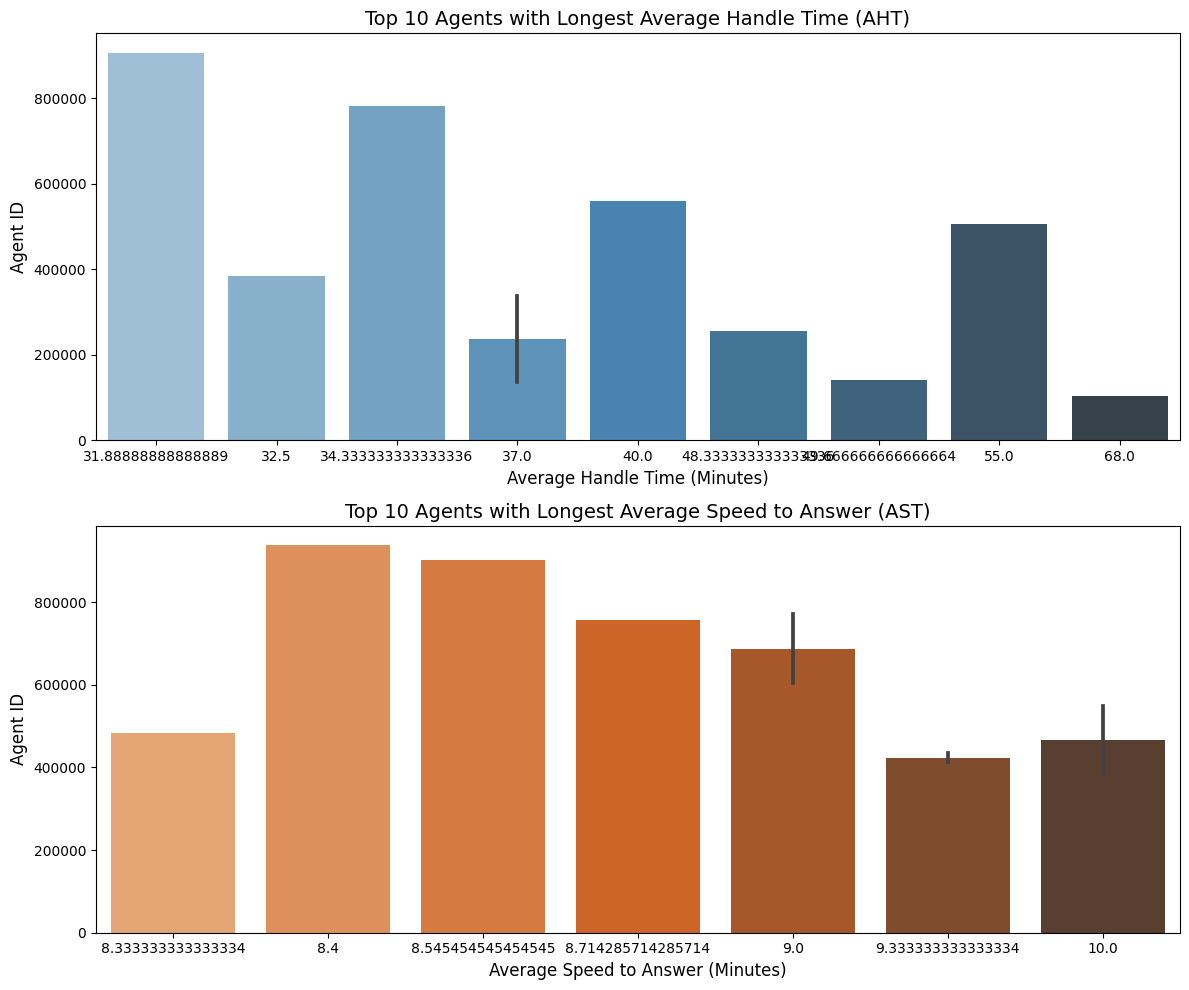

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plotting top agents by AHT
sns.barplot(x='AHT_minutes', y='agent_id_x', data=top_agents_by_aht, ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 10 Agents with Longest Average Handle Time (AHT)', fontsize=14)
axes[0].set_xlabel('Average Handle Time (Minutes)', fontsize=12)
axes[0].set_ylabel('Agent ID', fontsize=12)

# Plotting top agents by AST
sns.barplot(x='AST_minutes', y='agent_id_x', data=top_agents_by_ast, ax=axes[1], palette="Oranges_d")
axes[1].set_title('Top 10 Agents with Longest Average Speed to Answer (AST)', fontsize=14)
axes[1].set_xlabel('Average Speed to Answer (Minutes)', fontsize=12)
axes[1].set_ylabel('Agent ID', fontsize=12)

plt.tight_layout()
plt.show()


# Correaltions 

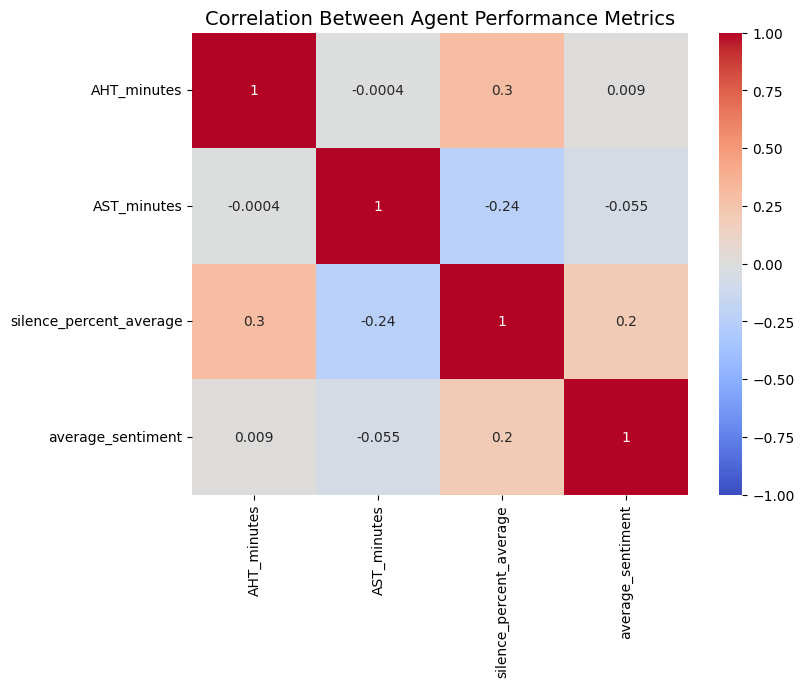

(   agent_id_x  AHT_minutes  AST_minutes  silence_percent_average  \
 0      102574    68.000000     8.000000                 0.260000   
 1      103651    19.469799     7.013423                 0.293389   
 2      106000    18.787611     7.300885                 0.274956   
 3      107876    24.333333     7.833333                 0.405000   
 4      112609    22.272727     8.090909                 0.286364   
 
    average_sentiment  
 0          -0.075000  
 1          -0.027953  
 2          -0.032124  
 3          -0.065000  
 4          -0.020909  ,
      agent_id_x  AHT_minutes  AST_minutes  silence_percent_average  \
 0        102574    68.000000     8.000000                 0.260000   
 160      506130    55.000000     7.000000                 0.390000   
 16       140146    49.666667     6.000000                 0.420000   
 60       255256    48.333333     4.666667                 0.443333   
 187      558705    40.000000     7.000000                 0.180000   
 13       136

In [88]:

# correlations between agent performance metrics(AHT,AST,silence,sentiment)
correlation_matrix = agent_performance_df[['AHT_minutes', 'AST_minutes', 'silence_percent_average', 'average_sentiment']].corr()

# heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Agent Performance Metrics', fontsize=14)
plt.show()

agent_performance_df.head(), top_agents_by_aht, top_agents_by_ast

In [89]:
print(merged_sentiment_df.columns)

Index(['call_id', 'customer_id', 'agent_id_x', 'call_start_datetime',
       'agent_assigned_datetime', 'call_end_datetime', 'call_transcript',
       'AHT_minutes', 'AST_minutes', 'primary_call_reason', 'agent_id_y',
       'agent_tone', 'customer_tone', 'average_sentiment',
       'silence_percent_average'],
      dtype='object')
